# 02 – Data Cleaning & Exploratory Data Analysis (EDA)

This notebook loads the raw scraped data from SQLite, cleans and standardizes the
variables, enriches the dataset with official BFS construction-period categories,
and performs exploratory data analysis to prepare the data for modeling.

### Contents

1. Load raw scraped data from SQLite  
2. Clean and standardize variables  
3. Map listings to BFS Bauperiode categories  
4. Compute derived variables (e.g., CHF/m², m²/CHF)  
5. Exploratory Data Analysis (EDA), including:  
   - Summary statistics and missing-value overview 
   - Correlation heatmap of continuous variables   
   - Average CHF/m² per Bauperiode (barplot)  
   - Distribution of CHF/m² across Bauperiode groups (boxplot) 
   - Count of listings per Bauperiode (countplot)   
   - Rent vs. construction year (scatterplot)  
  

The cleaned and enriched dataset produced in this notebook serves as the input for  
**Notebook 03 – Modeling, Statistical Testing, and Geographic Visualization**.




### 1. Load Raw Data from SQLite
We load:
- BFS construction period categories
- Raw scraped rental listings


In [16]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("../Data/apartment_database.db")

df_bauperiode = pd.read_sql("SELECT * FROM bfs_bauperiode_categories", conn)
df_raw = pd.read_sql("SELECT * FROM rental_listings_raw", conn)

conn.close()

df_raw.head()


,web_scraper_order,id,web_scraper_start_url,link_pages,link_listings,area_m2_raw,area_m2,rooms_raw,rent_chf_raw,rent_chf,year_built_raw,address,canton
0,1764272678-4,1,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/4002530569,134 m2,134,5.5,"2,530.–",2530,1984,"Kesslernmattstr. 14, 8965 Berikon",Zurich
1,1764272681-5,2,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/4002542635,98 m2,98,3.5,"2,255.–",2255,1989,"Im Spitzler 21, 8902 Urdorf",Zurich
2,1764272684-6,3,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/4002551340,68 m2,68,3.5,"1,945.–",1945,1973,"Ferdinand Hodler-Str. 14, 8049 Zürich",Zurich
3,1764272687-7,4,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/4002567338,134 m2,134,5.5,"5,590.–",5590,1906,"Weinbergstrasse 72, 8006 Zürich",Zurich
4,1764272699-10,5,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/4002572292,94 m2,94,4.5,"2,360.–",2360,1971,"Bahnhofstr. 73, 8957 Spreitenbach",Zurich


### Missing-Value Overview

Before cleaning, we inspect whether the dataset contains missing values in key
variables such as area, rooms, rent, or construction year. This ensures
transparency about data completeness before conducting further analysis.


In [17]:
df_raw.info()
df_raw.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   web_scraper_order      120 non-null    object 
 1   id                     120 non-null    int64  
 2   web_scraper_start_url  120 non-null    object 
 3   link_pages             120 non-null    object 
 4   link_listings          120 non-null    object 
 5   area_m2_raw            120 non-null    object 
 6   area_m2                120 non-null    int64  
 7   rooms_raw              120 non-null    float64
 8   rent_chf_raw           120 non-null    object 
 9   rent_chf               120 non-null    int64  
 10  year_built_raw         120 non-null    int64  
 11  address                120 non-null    object 
 12  canton                 120 non-null    object 
dtypes: float64(1), int64(4), object(8)
memory usage: 12.3+ KB


,web_scraper_order,id,web_scraper_start_url,link_pages,link_listings,area_m2_raw,area_m2,rooms_raw,rent_chf_raw,rent_chf,year_built_raw,address,canton
0,1764272678-4,1,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/4002530569,134 m2,134,5.5,"2,530.–",2530,1984,"Kesslernmattstr. 14, 8965 Berikon",Zurich
1,1764272681-5,2,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/4002542635,98 m2,98,3.5,"2,255.–",2255,1989,"Im Spitzler 21, 8902 Urdorf",Zurich
2,1764272684-6,3,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/4002551340,68 m2,68,3.5,"1,945.–",1945,1973,"Ferdinand Hodler-Str. 14, 8049 Zürich",Zurich
3,1764272687-7,4,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/4002567338,134 m2,134,5.5,"5,590.–",5590,1906,"Weinbergstrasse 72, 8006 Zürich",Zurich
4,1764272699-10,5,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/real-estate/city-...,https://www.homegate.ch/rent/4002572292,94 m2,94,4.5,"2,360.–",2360,1971,"Bahnhofstr. 73, 8957 Spreitenbach",Zurich


### 2. Clean Scraped Listings
We remove unnecessary columns from the web scraper, rename columns for clarity, and ensure all numerical fields are properly typed. 


In [18]:
# Remove columns that are irrelevant for analysis
cols_to_drop = [
    "web_scraper_order",
    "web_scraper_start_url",
    "link_pages",
    "link_listings",
    "area_m2_raw",
    "rent_chf_raw"
]

df_clean = df_raw.drop(columns=cols_to_drop, errors="ignore")

# Rename columns
df_clean = df_clean.rename(columns={
    "rooms_raw": "rooms",
    "year_built_raw": "year_built"
})

# Ensure numeric types
for col in ["rent_chf", "area_m2", "rooms", "year_built"]:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

df_clean.head()


,id,area_m2,rooms,rent_chf,year_built,address,canton
0,1,134,5.5,2530,1984,"Kesslernmattstr. 14, 8965 Berikon",Zurich
1,2,98,3.5,2255,1989,"Im Spitzler 21, 8902 Urdorf",Zurich
2,3,68,3.5,1945,1973,"Ferdinand Hodler-Str. 14, 8049 Zürich",Zurich
3,4,134,5.5,5590,1906,"Weinbergstrasse 72, 8006 Zürich",Zurich
4,5,94,4.5,2360,1971,"Bahnhofstr. 73, 8957 Spreitenbach",Zurich


### 3. Map Year Built to BFS Bauperiode Categories
We now map each rental listing's year of construction into one of the 12 official BFS construction age categories. 

In [19]:
def map_bauperiode(year):
    """Map construction year to BFS building-age category."""
    if pd.isna(year):
        return "Unknown"
    year = int(year)
    if year < 1919: return "Vor 1919 erbaut"
    if year <= 1945: return "Zwischen 1919 und 1945 erbaut"
    if year <= 1960: return "Zwischen 1946 und 1960 erbaut"
    if year <= 1970: return "Zwischen 1961 und 1970 erbaut"
    if year <= 1980: return "Zwischen 1971 und 1980 erbaut"
    if year <= 1990: return "Zwischen 1981 und 1990 erbaut"
    if year <= 2000: return "Zwischen 1991 und 2000 erbaut"
    if year <= 2005: return "Zwischen 2001 und 2005 erbaut"
    if year <= 2010: return "Zwischen 2006 und 2010 erbaut"
    if year <= 2015: return "Zwischen 2011 und 2015 erbaut"
    if year <= 2020: return "Zwischen 2016 und 2020 erbaut"
    if year <= 2024: return "Zwischen 2021 und 2024 erbaut"
    return "Unknown"

df_clean["bauperiode"] = df_clean["year_built"].apply(map_bauperiode)

df_clean[["year_built", "bauperiode"]].head()


,year_built,bauperiode
0,1984,Zwischen 1981 und 1990 erbaut
1,1989,Zwischen 1981 und 1990 erbaut
2,1973,Zwischen 1971 und 1980 erbaut
3,1906,Vor 1919 erbaut
4,1971,Zwischen 1971 und 1980 erbaut


### 4. Compute Derived Metrics (CHF/m² & m²/CHF)
We compute two core affordability metrics:

- CHF/m² = rent_chf / area_m2
- m²/CHF = area_m2 / rent_chf

These metrics allow comparison between building age categories.

In [20]:
df_clean["chf_per_m2"] = df_clean["rent_chf"] / df_clean["area_m2"]
df_clean["m2_per_chf"] = df_clean["area_m2"] / df_clean["rent_chf"]

df_clean[["rent_chf", "area_m2", "chf_per_m2", "m2_per_chf"]].head()


,rent_chf,area_m2,chf_per_m2,m2_per_chf
0,2530,134,18.880597,0.052964
1,2255,98,23.010204,0.043459
2,1945,68,28.602941,0.034961
3,5590,134,41.716418,0.023971
4,2360,94,25.106383,0.039831


### Save Cleaned Data for Later Use
We save the cleaned dataset back into SQLite so it can be used for modeling in Notebook 03.

In [21]:
conn = sqlite3.connect("../Data/apartment_database.db")
df_clean.to_sql("rental_listings_clean", conn, if_exists="replace", index=False)
conn.close()


### 5. Exploratory Data Analysis (EDA)
We now visualize:

- Average CHF/m² per Bauperiode
- Distribution of CHF/m²
- Rent vs. construction year
- Count of listings per Bauperiode
- Correlation heatmap of continuous variables
- Summary statistics

These visualizations help identify value trends across building age groups.

#### Summary Statistics

In [22]:
import sqlite3
import pandas as pd

# Reload cleaned dataset from SQLite
conn = sqlite3.connect("../Data/apartment_database.db")
df_clean = pd.read_sql("SELECT * FROM rental_listings_clean", conn)
conn.close()

df_clean.head()

,id,area_m2,rooms,rent_chf,year_built,address,canton,bauperiode,chf_per_m2,m2_per_chf
0,1,134,5.5,2530,1984,"Kesslernmattstr. 14, 8965 Berikon",Zurich,Zwischen 1981 und 1990 erbaut,18.880597,0.052964
1,2,98,3.5,2255,1989,"Im Spitzler 21, 8902 Urdorf",Zurich,Zwischen 1981 und 1990 erbaut,23.010204,0.043459
2,3,68,3.5,1945,1973,"Ferdinand Hodler-Str. 14, 8049 Zürich",Zurich,Zwischen 1971 und 1980 erbaut,28.602941,0.034961
3,4,134,5.5,5590,1906,"Weinbergstrasse 72, 8006 Zürich",Zurich,Vor 1919 erbaut,41.716418,0.023971
4,5,94,4.5,2360,1971,"Bahnhofstr. 73, 8957 Spreitenbach",Zurich,Zwischen 1971 und 1980 erbaut,25.106383,0.039831


In [23]:
summary_stats = df_clean[[
    "area_m2",
    "rooms",
    "rent_chf",
    "year_built",
    "chf_per_m2",
    "m2_per_chf"
]].describe().T

summary_stats

,count,mean,std,min,25%,50%,75%,max
area_m2,120.0,90.191667,25.034194,40.000000,71.000000,86.000000,102.000000,193.000000
rooms,120.0,3.654167,0.774585,2.500000,3.500000,3.500000,4.500000,5.500000
rent_chf,120.0,2599.975000,1037.842660,1180.000000,1800.000000,2277.500000,3027.500000,7350.000000
year_built,120.0,1989.466667,31.661533,1890.000000,1964.750000,1994.000000,2016.500000,2025.000000
chf_per_m2,120.0,29.267696,9.649313,17.142857,22.282130,26.378882,35.606618,68.750000
m2_per_chf,120.0,0.037378,0.010548,0.014545,0.028088,0.037909,0.044879,0.058333


#### Correlation Heatmap of Continuous Variables
We compute a Pearson correlation matrix to assess relationships among key
continuous features before modeling.

In [24]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../Data/apartment_database.db")
df = pd.read_sql("SELECT * FROM rental_listings_clean", conn)
conn.close()

df.head()

,id,area_m2,rooms,rent_chf,year_built,address,canton,bauperiode,chf_per_m2,m2_per_chf
0,1,134,5.5,2530,1984,"Kesslernmattstr. 14, 8965 Berikon",Zurich,Zwischen 1981 und 1990 erbaut,18.880597,0.052964
1,2,98,3.5,2255,1989,"Im Spitzler 21, 8902 Urdorf",Zurich,Zwischen 1981 und 1990 erbaut,23.010204,0.043459
2,3,68,3.5,1945,1973,"Ferdinand Hodler-Str. 14, 8049 Zürich",Zurich,Zwischen 1971 und 1980 erbaut,28.602941,0.034961
3,4,134,5.5,5590,1906,"Weinbergstrasse 72, 8006 Zürich",Zurich,Vor 1919 erbaut,41.716418,0.023971
4,5,94,4.5,2360,1971,"Bahnhofstr. 73, 8957 Spreitenbach",Zurich,Zwischen 1971 und 1980 erbaut,25.106383,0.039831


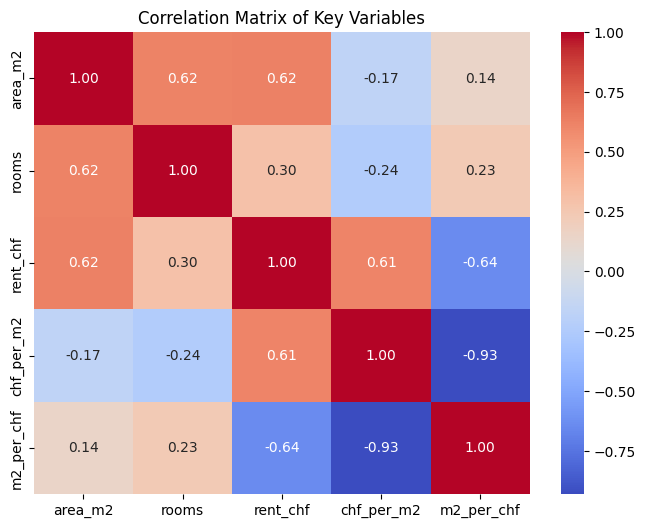

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = df[["area_m2", "rooms", "rent_chf", "chf_per_m2", "m2_per_chf"]].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Variables")
plt.show()

### Interpretation of the Correlation Matrix

The correlation matrix highlights several intuitive and relevant relationships
between apartment characteristics:

1. **Area (m²) and rent (CHF)** show a strong positive correlation (r = 0.62).
   Larger apartments tend to have higher absolute rents, which is expected.

2. **Area and CHF per m²** are weakly negatively correlated (r = -0.17).
   This reflects a typical market pattern: smaller units tend to have a higher
   price per m², while larger units offer more space at a lower marginal cost.

3. **Rent (CHF) and CHF per m²** are positively correlated (r = 0.61).
   Higher-priced apartments also tend to have higher rents per m², suggesting
   that price levels reinforce each other across the market.

4. **CHF per m² and m² per CHF** are very strongly negatively correlated
   (r = -0.93). This is mathematically expected because they are inverse metrics
   (one measures cost per unit area, the other area per unit cost).

5. **Rooms correlate strongly with area (r = 0.62)** and moderately with rent
   (r = 0.30), reflecting that room count is a rough proxy for apartment size.

Overall, no correlation appears excessively high (above |0.8|) except the
mathematically linked pair (CHF/m² vs. m²/CHF). This suggests that
multicollinearity is not a major issue for the OLS model, and the selected
features are suitable for regression analysis.

#### Setup 

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="Set2")


In [27]:
# Define correct BFS chronological order
bauperiode_order = [
    "Vor 1919 erbaut",
    "Zwischen 1919 und 1945 erbaut",
    "Zwischen 1946 und 1960 erbaut",
    "Zwischen 1961 und 1970 erbaut",
    "Zwischen 1971 und 1980 erbaut",
    "Zwischen 1981 und 1990 erbaut",
    "Zwischen 1991 und 2000 erbaut",
    "Zwischen 2001 und 2005 erbaut",
    "Zwischen 2006 und 2010 erbaut",
    "Zwischen 2011 und 2015 erbaut",
    "Zwischen 2016 und 2020 erbaut",
    "Zwischen 2021 und 2024 erbaut",
    "Unknown"
]

# Convert to ordered categorical
df_clean["bauperiode"] = pd.Categorical(
    df_clean["bauperiode"],
    categories=bauperiode_order,
    ordered=True
)


#### Barplot: Average CHF/m² by Bauperiode

We compare mean CHF per m² across BFS construction-period categories to identify
pricing differences between building-age groups.


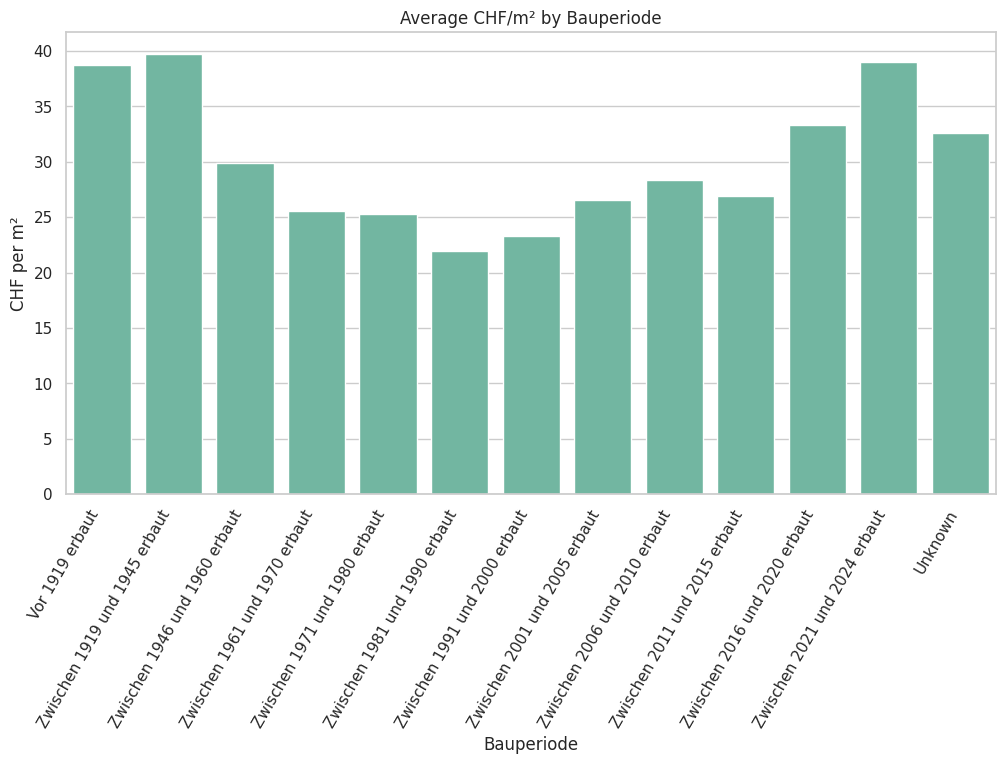

In [28]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_clean, x="bauperiode", y="chf_per_m2", errorbar=None)
plt.xticks(rotation=60, ha="right")
plt.title("Average CHF/m² by Bauperiode")
plt.ylabel("CHF per m²")
plt.xlabel("Bauperiode")
plt.show()


#### Interpretation of Average CHF/m² by Bauperiode

The barplot shows a clear pattern in rental price levels across construction periods:

- **Very old buildings (pre-1945)** exhibit the **highest CHF/m² values** (around 38–40 CHF/m²).  
  These apartments are often centrally located historical buildings (Altbau) that remain highly desirable and are frequently renovated.

- **Mid-century buildings (1946–1990)** show the **lowest price levels**, typically between 22–27 CHF/m².  
  This reflects the more standardized post-war housing stock, which tends to be larger and less recently modernized.

- **Buildings constructed between 1991 and 2020** fall in a **middle price range**, neither particularly premium nor low-cost.

- **New buildings (2021–2024)** again reach **premium price levels**, similar to the very old stock.  
  This is consistent with modern amenities, sustainability standards, and high demand for newly built housing.

- **Listings with unknown construction year** lie in the mid-to-upper range, likely reflecting renovated apartments or incomplete platform metadata.

Overall, the trend is **U-shaped**:  
**Very old** and **very new** buildings are the most expensive per m², while **mid-century buildings** are the most affordable.


#### Boxplot: Distribution of CHF/m² across Bauperiode groups
We examine the spread and variability of CHF per m² for each construction-period
group to identify outliers and distribution differences.

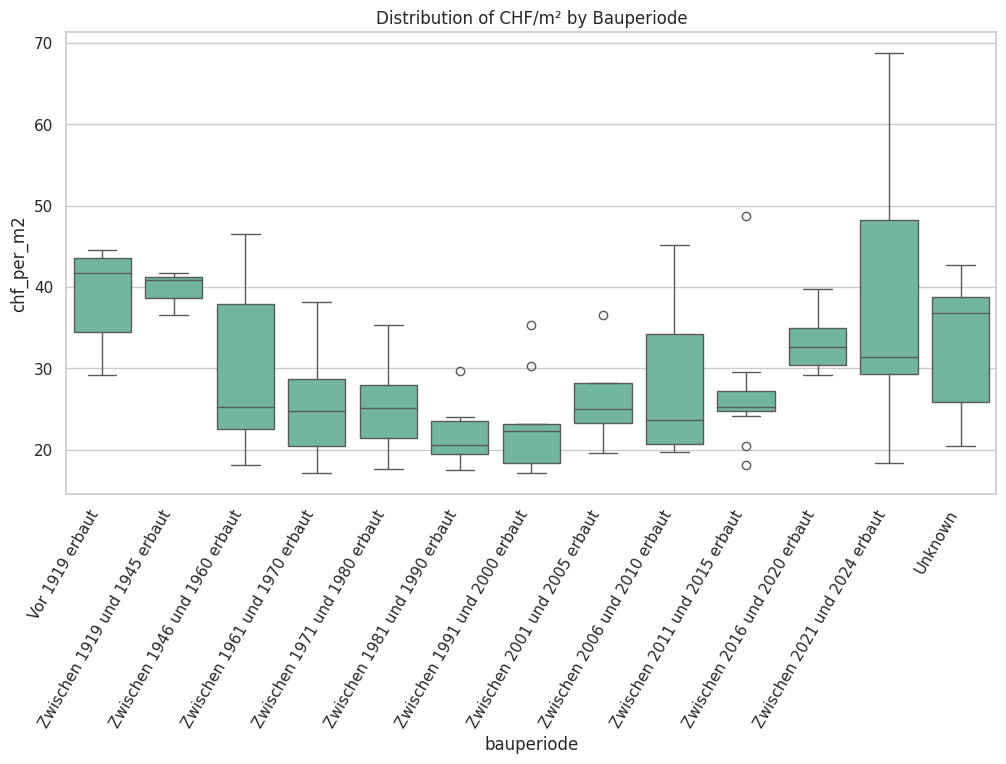

In [29]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_clean, x="bauperiode", y="chf_per_m2")
plt.xticks(rotation=60, ha="right")
plt.title("Distribution of CHF/m² by Bauperiode")
plt.show()


#### Interpretation of CHF/m² Distribution by Bauperiode (Boxplot)

The boxplot provides a detailed view of the variation in CHF/m² within each construction period. Several insights emerge:

- **Very old buildings (pre-1945)** show **high median rents and tight distributions**, indicating consistently expensive Altbau apartments with relatively little variation.

- **Buildings from 1946–1990** again display the **lowest medians** and the **narrowest spreads**, confirming that mid-century housing represents the most affordable segment in our dataset.  
  These groups also have fewer extreme outliers, suggesting more homogeneous housing quality.

- **Construction periods from 1991–2015** show **moderate medians** with wider spreads, reflecting greater heterogeneity in renovations, locations, and building standards.

- **New buildings (2021–2024)** have **very high medians** and the **largest interquartile range**.  
  This suggests both strong demand and substantial variability—likely due to differences in location quality, building amenities, and development types (urban vs. suburban).

- The **Unknown** category shows a wide spread and a relatively high median, suggesting that many of these listings may correspond to renovated units or incomplete platform metadata.

Overall, the boxplot reinforces the **U-shaped pattern** observed earlier:  
**Very old** and **very new** buildings command the highest CHF/m², while **mid-century buildings** are the most affordable with the lowest price dispersion.


#### Countplot: Number of Listings per Bauperiode
We visualize how many listings fall into each construction-period category to
assess data balance across groups.

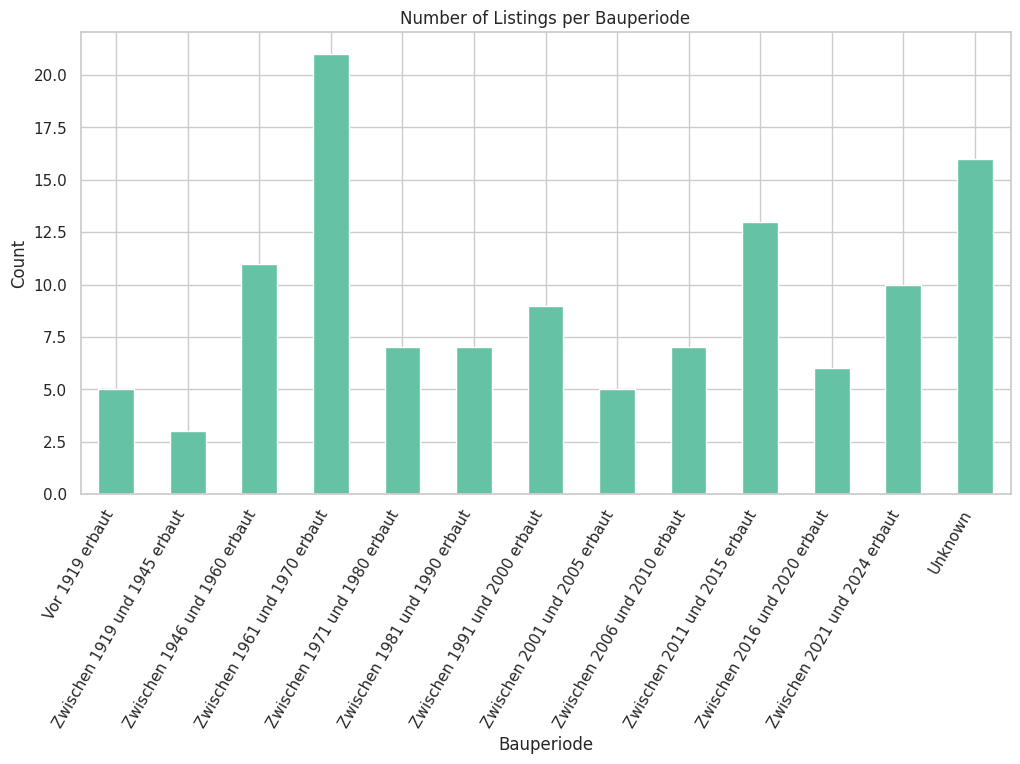

In [30]:
plt.figure(figsize=(12,6))

df_clean["bauperiode"].value_counts().reindex(bauperiode_order).plot(kind="bar")

plt.title("Number of Listings per Bauperiode")
plt.xlabel("Bauperiode")
plt.ylabel("Count")
plt.xticks(rotation=60, ha="right")
plt.show()

### Interpretation of Number of Listings per Bauperiode

Overall, the countplot shows that while all Bauperiode categories are represented,
the dataset is **imbalanced**, largely due to scraping variability.  
This imbalance needs to be considered when interpreting visualizations,
ANOVA tests, and regression coefficients that use Bauperiode as a predictor.

#### Scatterplot: Rent vs. Year Built
We explore whether newer or older buildings tend to have higher or lower listed
rents by plotting rent against construction year.

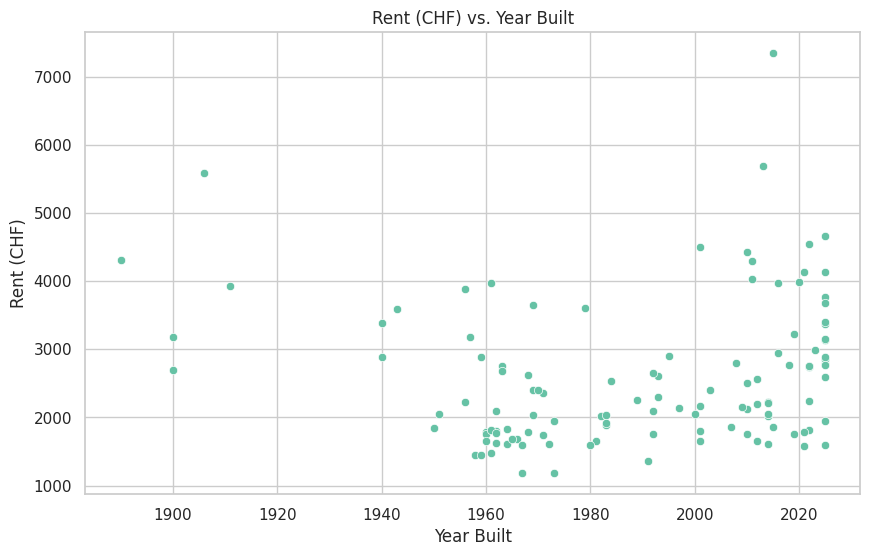

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean, x="year_built", y="rent_chf")
plt.title("Rent (CHF) vs. Year Built")
plt.xlabel("Year Built")
plt.ylabel("Rent (CHF)")
plt.show()


#### Interpretation of Rent (CHF) vs. Year Built

The scatterplot illustrates how monthly rent levels vary with the construction year of each building:

- **Newer buildings (1990–2024)** tend to cluster at **higher rent levels**, particularly between CHF 2,500 and CHF 4,500.  
  This reflects higher construction standards, modern amenities, and stronger demand for newer housing.

- **Mid-century buildings (1946–1980)** form a dense cluster of **lower rents**, typically between CHF 1,500 and CHF 2,500.  
  These apartments represent older but still functional housing stock, often without extensive renovation.

- **Very old buildings (pre-1945)** show **high variability**, including some of the **highest rents in the dataset**.  
  This likely reflects well-located historical units (Altbau) that have been renovated and remain attractive premium rentals.

- A few extreme high-rent points appear in **post-2000 constructions**, suggesting newly built luxury apartments.

Overall, the plot suggests a **positive relationship between newer construction and higher rents**, but with important exceptions:  
**renovated historical buildings** can also achieve top-tier rents, while many mid-century apartments remain the most affordable segment of the market.


### Summary and Transition to Modeling

The exploratory analysis provides several important insights:

- Apartment size and room count vary moderately and will serve as stable predictors.
- CHF per m² shows substantial variation across construction periods, supporting the use of OLS and ANOVA.
- The countplot reveals imbalanced sample sizes across the 12 BFS Bauperiode groups.
- The scatterplot indicates a positive relationship between newer construction and higher rents, with older renovated buildings also achieving premium values.

Because some Bauperiode categories are sparsely represented, we will consolidate
them into five broader construction-age groups in Notebook 03. This improves the
statistical reliability of both OLS dummy regression and ANOVA group comparisons.

Overall, Notebook 2 provides the cleaned dataset and analytical grounding
necessary for the modeling and statistical testing in **Notebook 03**.
